In [1]:
print("strawberry")

import torch
import numpy as np
import torch.nn.functional as F

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric,
    dice_loss
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import argparse

import torch.nn as nn
import torch
from torchmetrics import Metric
import math

strawberry


In [60]:
torch.manual_seed(42)

In [61]:
def two_class_prob(p_hat):
    p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_hat = p_hat[:,1,:] # select class 0
    return p_hat

def individual_dice(p_hat, y_true):
    p_hat = two_class_prob(p_hat)
    s0 = p_hat.shape[0]
    p_hat = p_hat.view(s0,-1)
    y_true = y_true.view(s0,-1)
    numerator = torch.sum(2. * p_hat * y_true, dim=1) + 1.
    denominator = torch.sum(y_true + p_hat, dim=1) + 1.
    combined = 1. - (numerator/denominator)
    return combined
    
def dice_loss(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    
    # is empties
    locs = torch.sum(y_true, dim=(-2, -1)) == 0
    wheres = torch.where(locs)[0]
    #print(wheres.shape)
    # print(wheres)
    #print(combined)
    r = 0.5
    combined[wheres] *= r
    #print(combined)
    
    return torch.sum(combined) / ((y_true.shape[0] - wheres.shape[0]) + (wheres.shape[0] * r))

def dice_loss_old(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    return torch.mean(combined)

In [62]:
def get_transforms(is_3D):
        transforms = [
            LabelSelect(label_id=1),
            RandomFlip(p=0.5, orientation="horizontal"),
            # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
            # GaussianNoise(p=0.2, mean=0, sigma=0.2),
            # RandomAffine(p=0.2, shear=(.1,3.)),
            # RandomAffine(p=0.2, degrees=5),
            #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

            RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
        ]
        if not is_3D:
            transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
            return PairedCompose(transforms)
        else:
            transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
            transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
            return PairedCompose(transforms)
        
def train_val_test_split(dataset, val_prop, test_prop, seed):
        # I think the sklearn version might be prefereable for determinism and things
        # but that involves fiddling with the dataset implementation I think....
        size = len(dataset)
        test_size = int(test_prop*size) 
        val_size = int(val_prop*size)
        train_size = size - val_size - test_size
        train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
        return train, val, test

In [5]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple

In [63]:
ckpt_dir = None
is3D = False
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

domains = [ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]]

test_proportion = 0.1
validation_proportion = 0.2
seed = 3407

# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

print(len(train_dataset), len(val_dataset), len(test_dataset))

8743 2497 1248


In [64]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

In [65]:
x, y = list(val_dataloader)[0]

In [66]:
x.shape

torch.Size([128, 3, 224, 160])

In [67]:
burden = y.sum(dim=(1,2))
highest = torch.sort(burden, descending=True)[1]

In [68]:
torch.max(x[:,0])

tensor(5.9070)

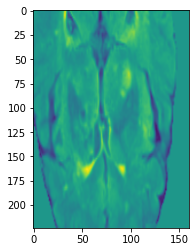

In [69]:
plt.imshow(x[highest[12]][0])

In [70]:
for x, y in train_dataloader:
    print((x[:,0].sum(dim=(1,2)) == 0).sum())

tensor(3)
tensor(1)
tensor(2)
tensor(3)
tensor(2)
tensor(4)
tensor(1)
tensor(3)
tensor(4)
tensor(4)
tensor(6)
tensor(1)
tensor(3)
tensor(1)
tensor(0)
tensor(3)
tensor(1)
tensor(3)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(5)
tensor(1)
tensor(1)
tensor(0)
tensor(2)
tensor(2)
tensor(0)
tensor(3)
tensor(0)
tensor(3)
tensor(2)
tensor(1)
tensor(1)
tensor(2)
tensor(3)
tensor(3)
tensor(1)
tensor(0)
tensor(0)
tensor(2)
tensor(0)
tensor(2)
tensor(1)
tensor(1)
tensor(0)
tensor(2)
tensor(1)
tensor(4)
tensor(1)
tensor(3)
tensor(1)
tensor(0)
tensor(1)
tensor(2)
tensor(2)
tensor(1)
tensor(3)
tensor(3)
tensor(3)
tensor(4)
tensor(1)
tensor(2)
tensor(2)
tensor(4)
tensor(3)
tensor(1)
tensor(0)


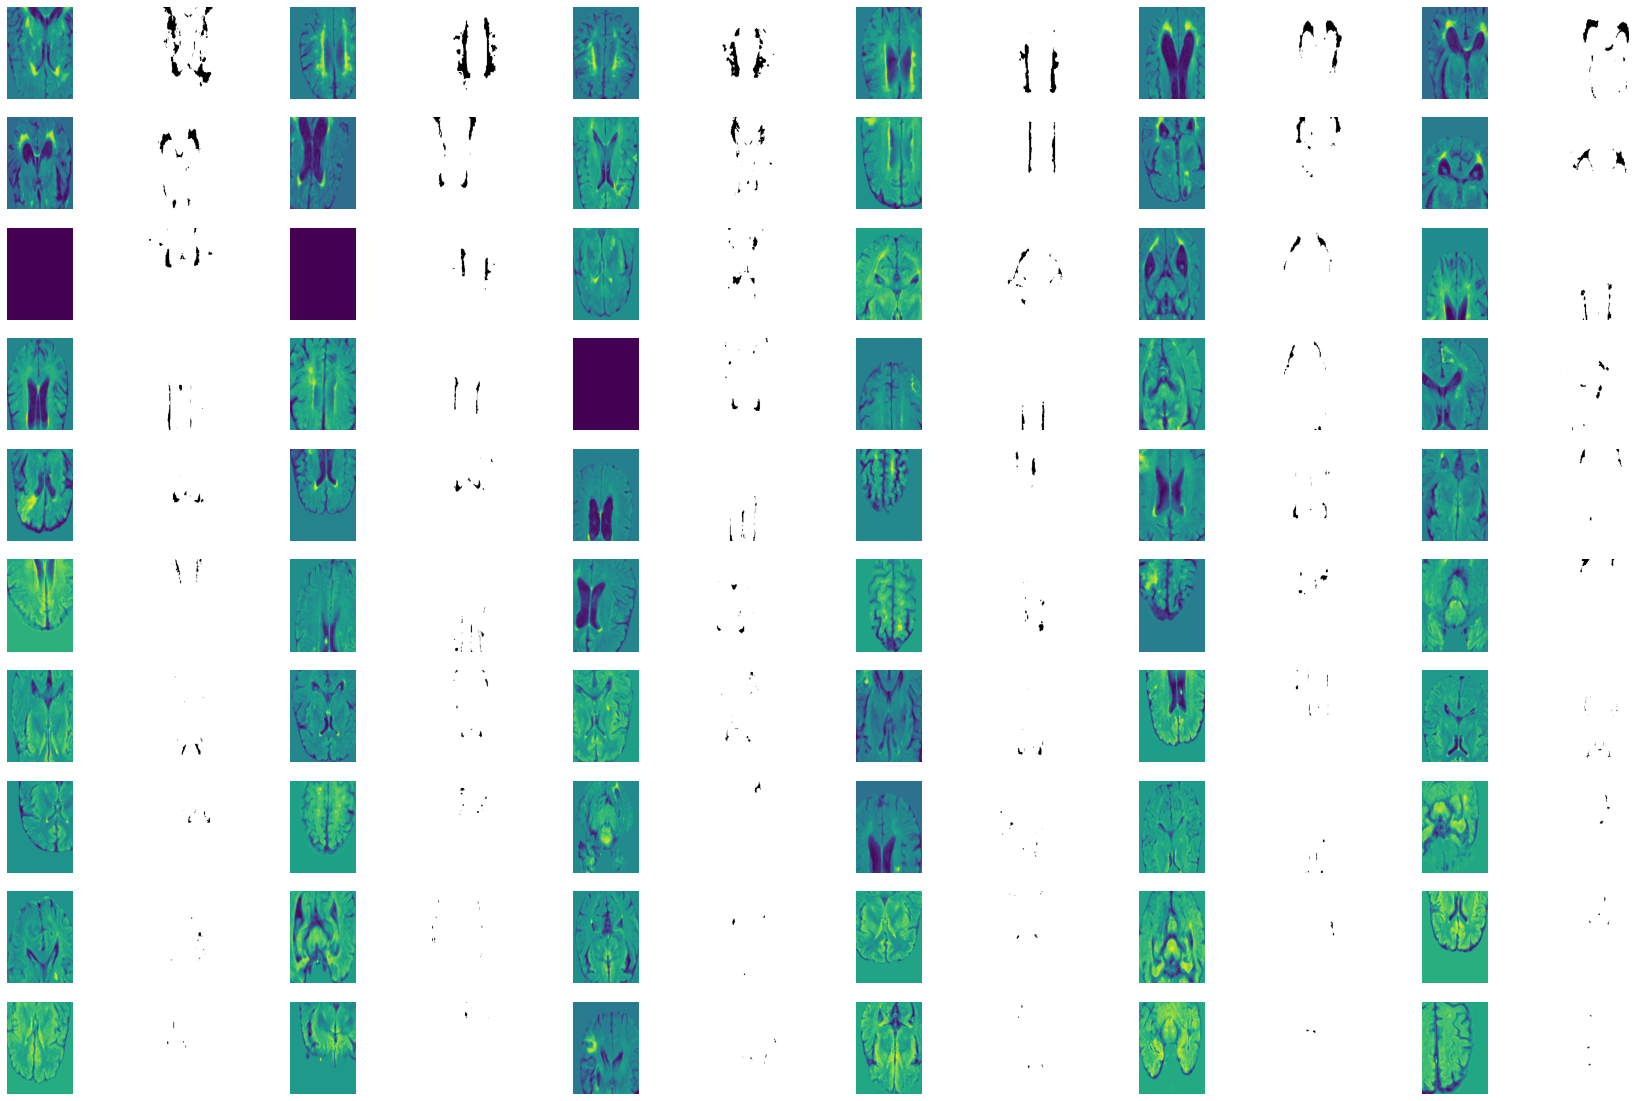

In [47]:
plt.figure(figsize=(30, 20))
count = 1
for i in range(0,60):
    plt.subplot(10, 12, count)
    plt.imshow(x[highest[i]][0].detach().cpu().numpy())
    plt.axis('off')
    plt.subplot(10, 12, count+1)
    plt.imshow(y[highest[i]].numpy(), cmap='Greys')
    plt.axis('off')
    count+=2